# Deep Autoencoder Networks

High-dimensional data can be converted to low-dimensional codes by training a multilayer neural
network with a small central layer to reconstruct high-dimensional input vectors.
This kind of neural network is named *Autoencoder*.

Autoencoders is *nonlinear dimensionality reduction* technique ([Hinton et al, 2006](https://www.cs.toronto.edu/~hinton/science.pdf)) used for unsupervised learning of features, and they can
 learn low-dimensional codes that work much
better than principal components analysis as a tool to reduce the dimensionality of data.

## Anomaly Heart Beats Detection

If enough training data
resembling some underlying pattern is provided, we can train the network to learn the patterns in the data.
An
anomalous test point is a point that does not match the typical data patterns. The autoencoder will
likely have a high error rate in reconstructing this data, indicating the anomaly.

This framework is used to develop an anomaly detection demonstration using a
deep autoencoder. The dataset is an ECG time series of heartbeats and the goal
is to determine which heartbeats are outliers. The training data (20 “good”
heartbeats) and the test data (training data with 3 “bad” heartbeats appended
for simplicity) can be downloaded directly into the H2O cluster, as shown below.
Each row represents a single heartbeat.

In [4]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 57 mins
H2O cluster version:,3.11.0.99999
H2O cluster version age:,9 hours and 4 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.48 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os.path
PATH = os.path.expanduser("~/h2o-3/")

In [6]:
train_ecg = h2o.import_file(PATH + "smalldata/anomaly/ecg_discord_train.csv")
test_ecg = h2o.import_file(PATH + "smalldata/anomaly/ecg_discord_test.csv")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


let's explore the dataset.

In [7]:
train_ecg.shape

(20, 210)

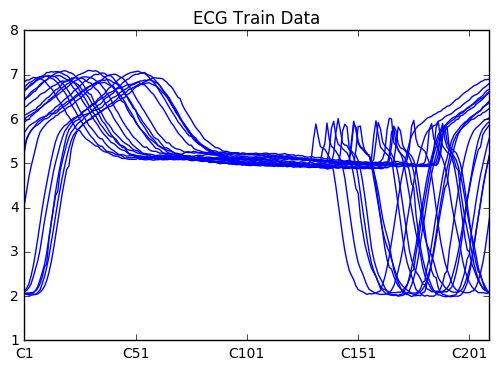

In [8]:
# transpose the frame to have the time serie as a single colum to plot
train_ecg.as_data_frame().T.plot(legend=False, title="ECG Train Data", color='blue'); # don't display the legend

in the train data we have 20 time series each of 210 data points. Notice that all the lines are compact and follow a similar shape. Is important to remember that when training with autoencoders you want to use only VALID data. All the anomalies should be removed.

Now let's use the AutoEncoderEstimator to train our neural network

In [15]:
model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[50], 
        l1=1e-5,
        score_interval=0,
        epochs=100
)

model.train(x=train_ecg.names, training_frame=train_ecg)             

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%


In [16]:
model

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1477202989522_3313
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 21,260 weights/biases, 274.4 KB, 2,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,210,Input,0.0,,,,,,,,,
,2,50,Tanh,0.0,1e-05,0.0,0.0057908,0.0025901,0.0,-0.0013594,0.0915895,0.0000773,0.0310732
,3,210,Tanh,,1e-05,0.0,0.0086898,0.0034284,0.0,-0.0007684,0.0904266,-0.0012694,0.0166782




ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.00247308999996
RMSE: 0.0497301719277
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2016-10-23 01:08:56,0.054 sec,0.00000 obs/sec,0.0,0,0.0,0.3882908,0.1507697
,2016-10-23 01:08:56,0.097 sec,4545 obs/sec,10.0,1,200.0,0.1252225,0.0156807
,2016-10-23 01:08:56,0.120 sec,6153 obs/sec,20.0,2,400.0,0.0969532,0.0093999
,2016-10-23 01:08:56,0.143 sec,7058 obs/sec,30.0,3,600.0,0.0812936,0.0066087
,2016-10-23 01:08:56,0.179 sec,8264 obs/sec,50.0,5,1000.0,0.0609603,0.0037162
,2016-10-23 01:08:56,0.197 sec,8759 obs/sec,60.0,6,1200.0,0.0562246,0.0031612
,2016-10-23 01:08:56,0.220 sec,8805 obs/sec,70.0,7,1400.0,0.0525046,0.0027567
,2016-10-23 01:08:56,0.236 sec,9195 obs/sec,80.0,8,1600.0,0.0503764,0.0025378
,2016-10-23 01:08:56,0.252 sec,9523 obs/sec,90.0,9,1800.0,0.0497302,0.0024731
,2016-10-23 01:08:56,0.269 sec,9852 obs/sec,100.0,10,2000.0,0.0503726,0.0025374


Our Neural Network is now able to *Encode* the time series.

Now we try to Compute reconstruction error with the Anomaly detection function.
This is the Mean Square Error between output and input layers.
Low error means that the neural network is able to encode the input well, and that means is a "known" case.
A High error means that the neural network has not seen that example before and so is an anomaly.

In [17]:
reconstruction_error = model.anomaly(test_ecg)

Now the question is: Which of the test_ecg time series are most likely an anomaly? 

We can select the top N that have high error rate

In [18]:
df = reconstruction_error.as_data_frame()

In [19]:
df['Rank'] = df['Reconstruction.MSE'].rank(ascending=False)

In [20]:
df_sorted = df.sort_values('Rank')
df_sorted

,Reconstruction.MSE,Rank
21,9.780837,1.0
22,7.441649,2.0
20,2.931406,3.0
14,0.004800,4.0
4,0.004101,5.0
16,0.003689,6.0
15,0.003129,7.0
18,0.003078,8.0
12,0.003051,9.0
6,0.002889,10.0


In [21]:
anomalies = df_sorted[ df_sorted['Reconstruction.MSE'] > 1.0 ]
anomalies

,Reconstruction.MSE,Rank
21,9.780837,1.0
22,7.441649,2.0
20,2.931406,3.0


In [22]:
data = test_ecg.as_data_frame()

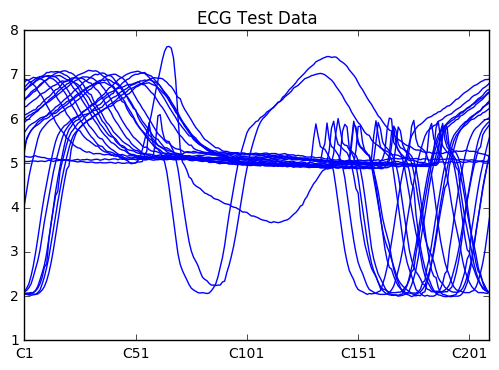

In [23]:
data.T.plot(legend=False, title="ECG Test Data", color='blue')

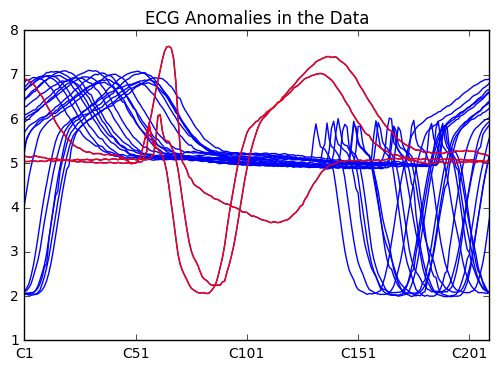

In [24]:
ax = data.T.plot(legend=False, color='blue')
data.T[anomalies.index].plot(legend=False, title="ECG Anomalies in the Data", color='red', ax=ax);

## Conclusions

In this tutorial you learned how to use the autoencoding capabilities of H2O to quickly detect time series anomalies using Autoencoders.

## Unsupervised Pre-training with Supervised Fine-Tuning

Sometimes, there is much more unlabeled data than labeled data.
It this case,
it might make sense to train an autoencoder model on the unlabeled data and
then fine-tune the learned model with the available labels.

[TODO](https://github.com/h2oai/h2o-3/blob/master/h2o-r/tests/testdir_algos/deeplearning/runit_deeplearning_stacked_autoencoder_large.R)
[https://github.com/h2oai/h2o-3/blob/master/h2o-py/tests/testdir_algos/deeplearning/pyunit_autoencoderDeepLearning_large.py](https://github.com/h2oai/h2o-3/blob/master/h2o-py/tests/testdir_algos/deeplearning/pyunit_autoencoderDeepLearning_large.py)